# AlexNet on FashionMNIST

Here we use Relus, Dropouts & higher pixel (224) to make the model. Hopefully, it will give us more accuracy.

In [1]:
device = "cuda"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [5]:
!rm -rf ./imitools && git clone https://github.com/GDi4K/imitools.git
!pip install -q duckduckgo_search
import imitools as I

Cloning into 'imitools'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 112 (delta 59), reused 34 (delta 15), pack-reused 0
Receiving objects: 100% (112/112), 4.44 MiB | 11.52 MiB/s, done.
Resolving deltas: 100% (59/59), done.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.12.0a0+293.g0930f712e6 requires pandas<1.4.0dev0,>=1.0, but you have pandas 1.4.2 which is incompatible.


In [8]:
transform_pil=transforms.Compose([
    transforms.ToTensor(), # first, convert image to PyTorch tensor
    transforms.Resize(224),
    transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
])

In [9]:
ds_train = datasets.FashionMNIST("~/data", train=True, download=True, transform=transform_pil)
ds_valid = datasets.FashionMNIST("~/data", train=True, download=True, transform=transform_pil)

In [12]:
ds_train[0][0].shape

torch.Size([1, 224, 224])

Yep. It's an image with 224px width. We need this to work with the AlexNet

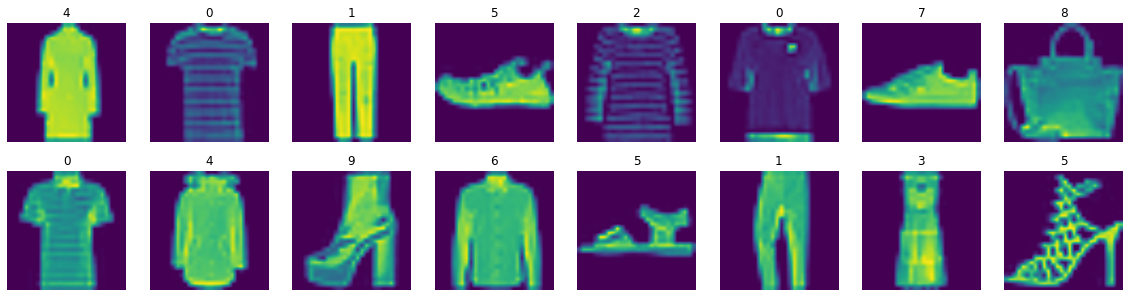

In [10]:
_dl = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=16)
sample_batch = next(iter(_dl))
I.wrap(*sample_batch).show(cols=8)

## Defining AlexNet

In [13]:
test_images = sample_batch[0].to(device)
test_images.shape

torch.Size([16, 1, 224, 224])

In [17]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
    
    def forward(self, images):
        return self.net(images)
    
_m = AlexNet().to(device)
_m(test_images).shape

torch.Size([16, 10])

## Training Loop

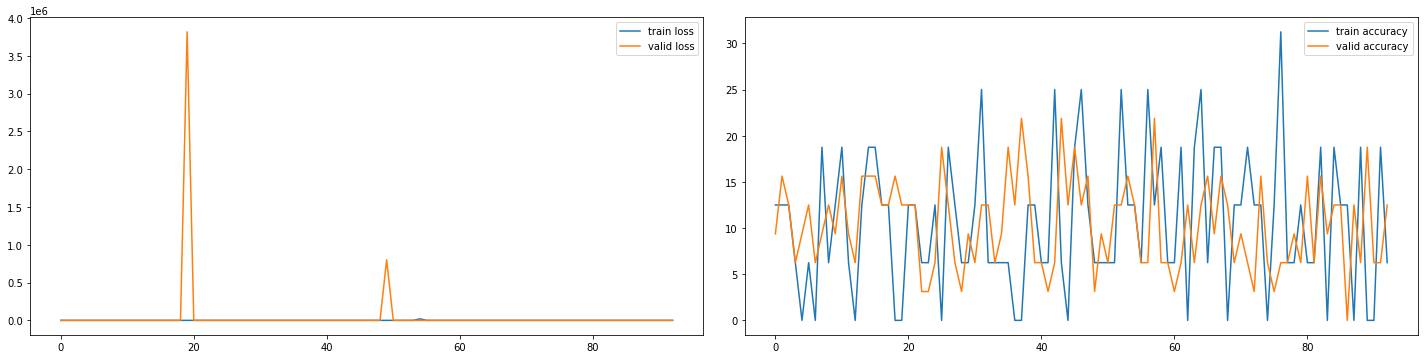

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

In [19]:
epochs = 5
bs = 32
lr = 0.005
wd = 0.005

dl_train = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=16)
model = AlexNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

loss_list = []
valid_loss_list = []
accuracy_list = []
valid_accuracy_list = []

def calc_accuracy(images, labels):
    batch_size = len(images)
    pred = model(images)
    pred = pred.detach()
    
    pred_labels = torch.argmax(pred, dim=-1)
    accuracy = (pred_labels == labels).sum() / batch_size * 100
    
    return accuracy

lp = I.live_plot(2)
i = 0

for epoch in range(epochs):
    for batch in tqdm(dl_train):
        i += 1;
        images = batch[0].to(device)
        labels = batch[1].to(device)
        batch_size = len(images)

        optimizer.zero_grad()

        yhat = model(images)
        loss = F.cross_entropy(yhat, labels)

        loss.backward()

        optimizer.step()

        if i %200 == 0:
            with torch.no_grad():
                accuracy_list.append(calc_accuracy(images, labels).cpu().item())
                loss_list.append(loss.item())
                
                _dl = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=bs)
                sample = next(iter(_dl))
                valid_images, valid_lables = sample[0].to(device), sample[1].to(device)
                
                valid_accuracy_list.append(calc_accuracy(valid_images, valid_lables).cpu().item())
                valid_loss = F.cross_entropy(model(valid_images), valid_lables)
                valid_loss_list.append(valid_loss.item())
                
            lp.plot(0, loss_list, label="train loss")
            lp.plot(0, valid_loss_list, label="valid loss")
            lp.plot(1, accuracy_list, label="train accuracy")
            lp.plot(1, valid_accuracy_list, label="valid accuracy")
            lp.update()
        
lp.close()

In [20]:
_dl = torch.utils.data.DataLoader(ds_valid, shuffle=True, batch_size=128)
accuracy_list = []
for batch in tqdm(_dl):
    images = batch[0].to(device)
    labels = batch[1].to(device)
    
    with torch.no_grad():
        accuracy_list.append(calc_accuracy(images, labels))
    
torch.tensor(accuracy_list).mean().item()

  0%|          | 0/469 [00:00<?, ?it/s]

9.987451553344727

**Well, it didn't improve in this case**

May be FMnist doesn't have enough data or it's we didn't spend too much time on it.